In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

#from feature_engine import discretizers as dsc

import networkx as nx
import pylab as plt
import time

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
df = pd.read_excel('Dataset\\World 2500 (2004-2020)\\SB2020_World2500.xlsx')

In [6]:
csfont = {'fontname':'Century'}
hfont = {'fontname':'Arial'}

In [23]:
df.head()

,World rank,Company,Country,Region,Industry,R&D 2019 (€million),R&D one-year growth (%),Net sales (€million),Net sales one-year growth (%),R&D intensity (%),Capex (€million),Capex one-year growth (%),Capex intensity (%),Op.profits (€million),Op.profits one-year growth (%),Profitability (%),Employees,Employees one-year growth (%),Market cap (€million),Market cap one-year growth (%)
0,1,ALPHABET,US,US,Software & Computer Services,23160.052790,24.369025,144077.817835,18.300090,16.074683,20961.369940,-6.328812,14.548645,31981.488840,10.225495,22.197372,118899.0,20.378451,317430.575596,-3.150728
1,2,MICROSOFT,US,US,Software & Computer Services,17152.396695,14.179900,127305.517325,13.645574,13.473412,13744.883355,10.886894,10.796770,47023.328030,23.042881,36.937384,163000.0,13.194444,936992.770363,22.202594
2,3,HUAWEI INVESTMENT & HOLDING,China,China,Technology Hardware & Equipment,16712.669680,31.228242,109416.700889,19.083558,15.274332,5238.499111,34.698290,4.787660,9916.303768,6.205739,9.062880,194000.0,3.191489,NaN,NaN
3,4,SAMSUNG ELECTRONICS,South Korea,RoW,Electronic & Electrical Equipment,15524.997456,8.270881,177139.830909,-5.484865,8.764261,22002.212850,-6.407620,12.420816,21349.349739,-52.844151,12.052258,287439.0,-7.166941,201949.731020,-15.544475
4,5,APPLE,US,US,Technology Hardware & Equipment,14435.643635,13.915426,231595.186970,-2.041078,6.233136,9342.176725,-21.167280,4.033839,56907.609150,-9.828204,24.572017,137000.0,3.787879,839713.172359,-14.198408


In [26]:
df.columns

Index(['World rank', 'Company', 'Country', 'Region', 'Industry',
       'R&D 2019 (€million)', 'R&D one-year growth (%)',
       'Net sales (€million)', 'Net sales one-year growth (%)',
       'R&D intensity (%)', 'Capex (€million)', 'Capex one-year growth (%)',
       'Capex intensity (%)', 'Op.profits (€million)',
       'Op.profits one-year growth (%)', 'Profitability (%)', 'Employees',
       'Employees one-year growth (%)', 'Market cap (€million)',
       'Market cap one-year growth (%)'],
      dtype='object')

In [41]:
def renaming_columns(df):##Renaming the columns
    for col in df.columns:
        new_col = col[0] + '_' + col[1].upper()
        df[new_col] = df[col[0]][col[1]]
        df.drop([col], axis = 1, inplace = True)
    return df

In [42]:
df_country = renaming_columns(df_country)

### AVERAGE

In [52]:
df_country_avg = df.groupby(by=["Country"])['R&D 2019 (€million)', 'Employees', 'Net sales (€million)', 'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'].mean()
df_country_avg.drop(index = 'Saudi Arabia', axis = 0, inplace = True) #Outlier

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Correlation Plot Between Average Values for Country')

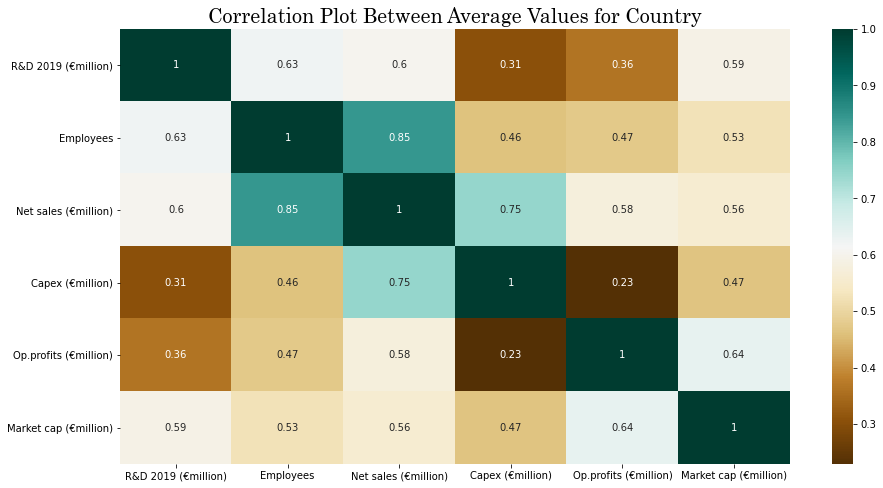

In [8]:
plt.figure(figsize = (15,8))
cormap = np.corrcoef(df_country_avg.values.T).round(2)
g = sns.heatmap(df_country_avg.corr(), cbar=True, annot = True, cmap='BrBG', yticklabels = df_country_avg.columns, xticklabels=df_country_avg.columns)
plt.title('Correlation Plot Between Average Values for Country', **csfont, size = 20)
plt.savefig(fname = 'Images/corr_plot_avg_country')

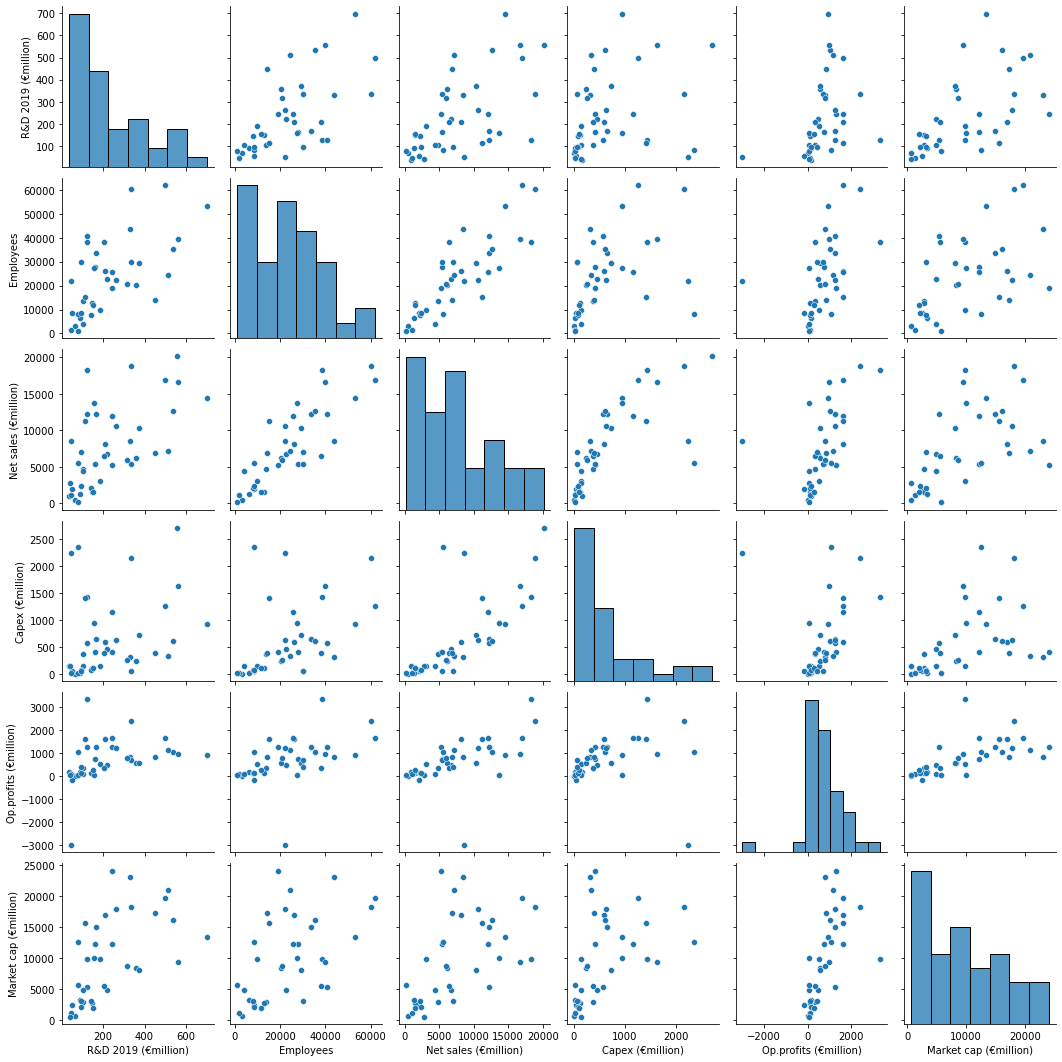

In [234]:
sns.pairplot(df_country_avg, palette = 'Reds')
plt.savefig('Images\\country_avg_pairplot.png') 

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='R&D 2019 (€million)', ylabel='Country'>

Text(0.5, 1.0, 'TOP 15 COUNTRIES FOR AVERAGE R&D INVESTMENTS 2019 (€million)')

Text(0, 0.5, 'Country')

Text(0.5, 0, 'R&D Investments 2019 (€million)')

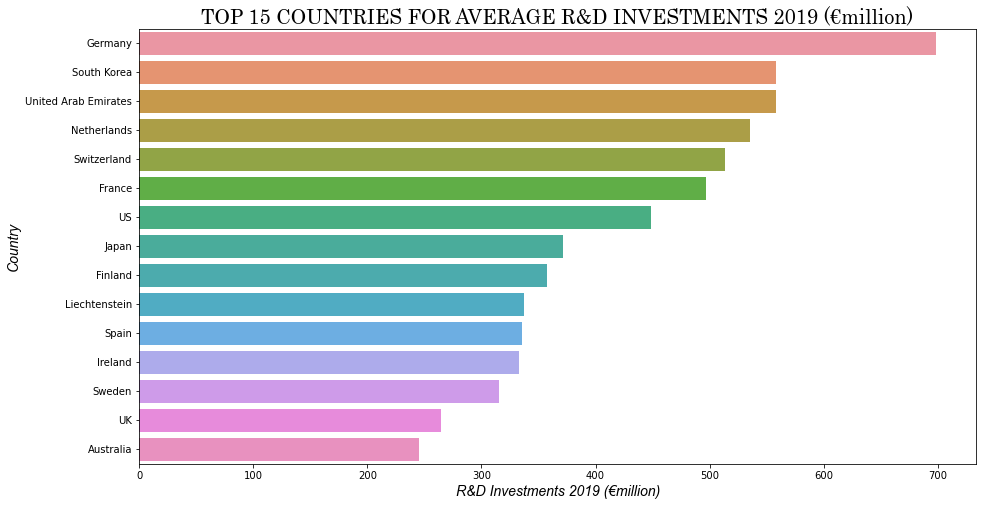

In [228]:
df_order = df_country_avg.sort_values(by='R&D 2019 (€million)', ascending = False)

plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['R&D 2019 (€million)'], 
            y = df_order[:15].index)
plt.title('TOP 15 COUNTRIES FOR AVERAGE R&D INVESTMENTS 2019 (€million)', **csfont, size = 20)
plt.ylabel('Country', **hfont, size = 14, style = 'italic')
plt.xlabel('R&D Investments 2019 (€million)', **hfont, size = 14, style = 'italic')
plt.savefig('Images\\RD_avg_country')

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Employees', ylabel='Country'>

Text(0.5, 1.0, 'TOP 15 COUNTRIES FOR AVERAGE EMPLOYEES')

Text(0, 0.5, 'Country')

Text(0.5, 0, 'Employees')

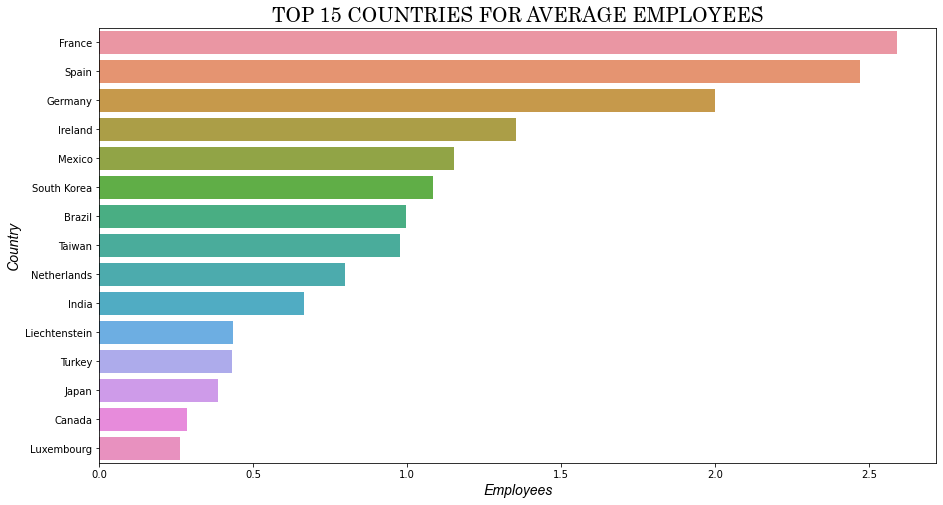

In [81]:
df_order = df_country_avg.sort_values(by='Employees', ascending = False)

plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['Employees'], 
            y = df_order[:15].index)
plt.title('TOP 15 COUNTRIES FOR AVERAGE EMPLOYEES', **csfont, size = 20)
plt.ylabel('Country', **hfont, size = 14, style = 'italic')
plt.xlabel('Employees', **hfont, size = 14, style = 'italic')

In [150]:
df_country_avg.columns

Index(['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
       'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'],
      dtype='object')

In [11]:
for column in df_country_avg.columns:
    if df_country_avg[column].isnull().values.any() == True:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_country_avg[column] = imputer.fit_transform(np.array(df_country_avg[column]).reshape(-1,1))
        
df_country_avg = df_country_avg.round(decimals = 3)

scaler = StandardScaler()

features = scaler.fit_transform(df_country_avg[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                                               'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']])
df_country_avg[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']] = features
y = df_country_avg['Net sales (€million)']
df_country_avg.drop(['Net sales (€million)'], axis = 1, inplace = True)

In [12]:
df_country_avg.drop(['Op.profits (€million)', 'Market cap (€million)'], axis = 1, inplace = True)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_country_avg, y, test_size=0.1, random_state=42)

### Linear Regression

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predicts = lr.predict(X_test)

LinearRegression()

In [41]:
r2_score(y_test, predicts)

0.6337302287989814

In [42]:
math.sqrt(mean_squared_error(y_test, predicts))

0.659000654968235

### Ridge

In [43]:
lasso = Ridge()
lasso.fit(X_train, y_train)
predicts = lasso.predict(X_test)

Ridge()

In [44]:
r2_score(y_test, predicts)

0.627413648831866

In [45]:
math.sqrt(mean_squared_error(y_test, predicts))

0.6646588294806761

### SVR

In [46]:
svr = SVR()
svr.fit(X_train, y_train)
predicts = svr.predict(X_test)

SVR()

In [47]:
r2_score(y_test, predicts)

0.8848150299487986

In [48]:
math.sqrt(mean_squared_error(y_test, predicts))

0.3695585160221925

### Random Forest 

In [49]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predicts = rf.predict(X_test)

RandomForestRegressor()

In [50]:
r2_score(y_test, predicts)

0.8549171561351453

In [51]:
math.sqrt(mean_squared_error(y_test, predicts))

0.41475663049948963

In [140]:
for column in df_country_avg.columns:
    if df_country_avg[column].isnull().values.any() == True:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_country_avg[column] = imputer.fit_transform(np.array(df_country_avg[column]).reshape(-1,1))
        
df_country_avg = df_country_avg.round(decimals = 3)

In [53]:
df_avg = df_country_avg.dropna()

In [220]:
for x in list(df_avg.columns):
        new_name = x.replace(' ', '.')
        new_name = new_name.replace('€', '')
        new_name = new_name.replace('(', '')
        new_name = new_name.replace(')', '')
        new_name = new_name.replace('&', '')
        df_avg.rename(columns = {x : new_name}, inplace = True)

Finding Elimination Order: : 100%|██████████████████████████████████████████████████████| 1/1 [10:02<00:00, 602.75s/it]


In [221]:
df_avg.columns

Index(['RD.2019.million', 'Employees', 'Net.sales.million', 'Capex.million',
       'Op.profits.million', 'Market.cap.million'],
      dtype='object')

In [223]:
df_avg.to_csv('Dataset\\df_avg_country.csv')

In [54]:
def computing_high_low(dataset, column, new_column):
    lvl = []
    mean_value = np.mean(dataset[column])
    for x in dataset[column]:
        if x >= mean_value:
            lvl.append('High')
        else:
            lvl.append('Low')

    dataset[new_column] = lvl
    return dataset

df_avg = computing_high_low(df_avg, 'R&D 2019 (€million)', 'Level_R&D')
df_avg = computing_high_low(df_avg, 'Employees', 'Level_Employees')
df_avg = computing_high_low(df_avg, 'Net sales (€million)', 'Level_Net_Sales')
df_avg = computing_high_low(df_avg, 'Capex (€million)', 'Level_Capex')
df_avg = computing_high_low(df_avg, 'Op.profits (€million)', 'Level_Op_Profits')
df_avg = computing_high_low(df_avg, 'Market cap (€million)', 'Level_Market_Cap')

In [55]:
df_avg.drop(['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
       'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'], axis = 1, inplace = True)

  0%|                                                                            | 8/1000000 [00:00<8:22:57, 33.14it/s]


<Figure size 1080x720 with 0 Axes>

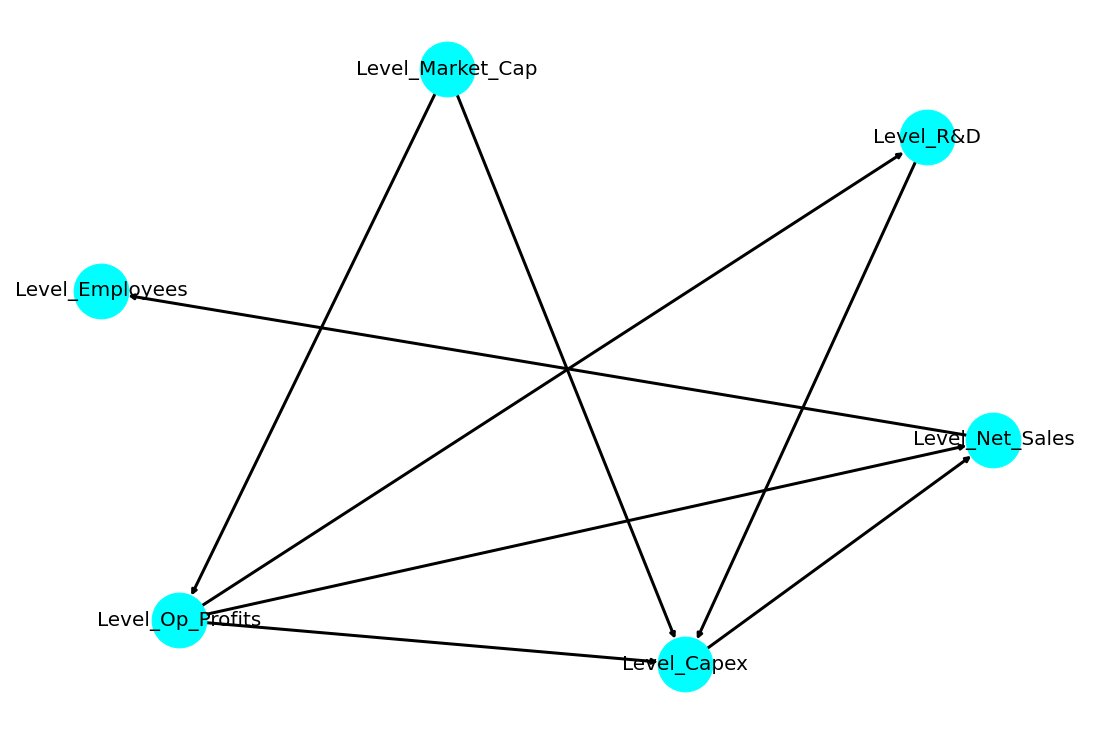

In [56]:
hc = HillClimbSearch(df_avg, scoring_method=BicScore(df_avg))
#The score to be optimized during structure estimation.  
#  Supported structure scores: k2score, bdeuscore, bicscore.
best_model = hc.estimate()
edges = list(best_model.edges())
model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))

# nx.draw(model, with_labels=True)
nx.draw(model, pos= nx.spring_layout(model), with_labels=True, node_size=3000,
        node_color="cyan", edge_color = 'black', width = 3, font_size = 20)
plt.savefig('Images\\beayesin_avg_country.png')
plt.show()

In [57]:
model.fit(df_avg, estimator=MaximumLikelihoodEstimator)

# Doing exact inference using Variable Elimination
infer = VariableElimination(model)

In [58]:
print(infer.query(variables=['Level_Employees', 'Level_R&D'], joint= True))

Eliminating: Level_Market_Cap: 100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 320.58it/s]

+-----------------+-----------------------+----------------------------------+
| Level_R&D       | Level_Employees       |   phi(Level_R&D,Level_Employees) |
+=================+=======================+==================================+
| Level_R&D(High) | Level_Employees(High) |                           0.2402 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(High) | Level_Employees(Low)  |                           0.1382 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(Low)  | Level_Employees(High) |                           0.2255 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(Low)  | Level_Employees(Low)  |                           0.3961 |
+-----------------+-----------------------+----------------------------------+


In [59]:
print(infer.query(variables=['Level_Employees'], evidence={'Level_R&D': 'High'}))


Finding Elimination Order: :   0%|                                                               | 0/4 [00:00<?, ?it/s]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Net_Sales:   0%|                                                              | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Capex:   0%|                                                                  | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Op_Profits:   0%|                                                             | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Market_Cap: 100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 501.32it/s]

+-----------------------+------------------------+
| Level_Employees       |   phi(Level_Employees) |
+=======================+========================+
| Level_Employees(High) |                 0.6349 |
+-----------------------+------------------------+
| Level_Employees(Low)  |                 0.3651 |
+-----------------------+------------------------+


In [209]:
print(infer.query(variables=['Level_Employees'], evidence={'Level_R&D': 'Low'}))


Finding Elimination Order: :   0%|                                                               | 0/4 [00:00<?, ?it/s]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Capex:   0%|                                                                  | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Market_Cap:   0%|                                                             | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Net_Sales:   0%|                                                              | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Op_Profits: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]

+-----------------------+------------------------+
| Level_Employees       |   phi(Level_Employees) |
+=======================+========================+
| Level_Employees(High) |                 0.3628 |
+-----------------------+------------------------+
| Level_Employees(Low)  |                 0.6372 |
+-----------------------+------------------------+


In [60]:
print(infer.query(variables=['Level_Net_Sales'], evidence={'Level_R&D': 'High', 'Level_Employees': 'High', 'Level_Capex':'High'}))



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|                                                               | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


Eliminating: Level_Market_Cap:   0%|                                                             | 0/2 [00:00<?, ?it/s]


Eliminating: Level_Op_Profits: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.35it/s]

+-----------------------+------------------------+
| Level_Net_Sales       |   phi(Level_Net_Sales) |
+=======================+========================+
| Level_Net_Sales(High) |                 0.9838 |
+-----------------------+------------------------+
| Level_Net_Sales(Low)  |                 0.0162 |
+-----------------------+------------------------+


In [61]:
print(infer.query(variables=['Level_Net_Sales'], evidence={'Level_R&D': 'Low', 'Level_Employees': 'Low', 'Level_Capex':'Low'}))




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


Eliminating: Level_Op_Profits: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 799.75it/s]

+-----------------------+------------------------+
| Level_Net_Sales       |   phi(Level_Net_Sales) |
+=======================+========================+
| Level_Net_Sales(High) |                 0.0021 |
+-----------------------+------------------------+
| Level_Net_Sales(Low)  |                 0.9979 |
+-----------------------+------------------------+


# INDUSTRY AVERAGE

In [98]:
df_industry_avg = df.groupby(by=["Industry"])['R&D 2019 (€million)', 'Employees', 'Net sales (€million)', 'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'].mean()
#df_industry_avg.drop(index = 'Oil & Gas Producers', axis = 0, inplace = True) #Outlier

Finding Elimination Order: : 100%|█████████████████████████████████████████████████| 2/2 [22:11:40<00:00, 39950.22s/it]


<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Correlation Plot Between Average Values for Industry')

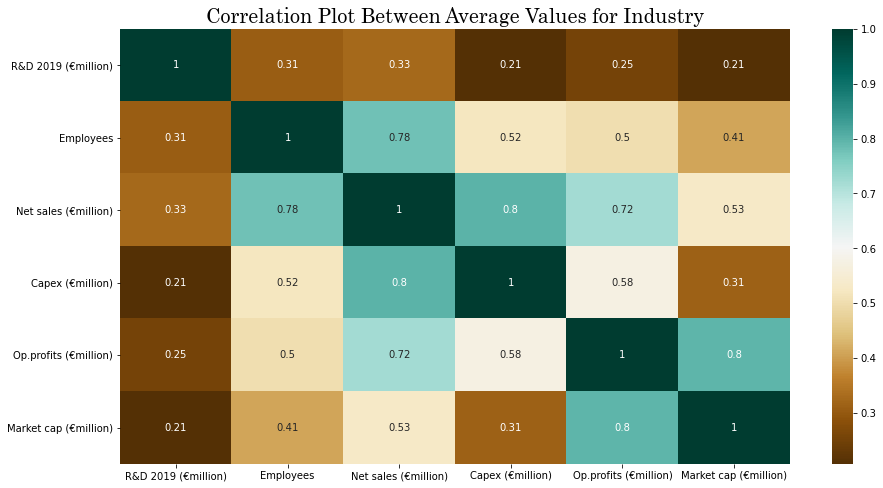

In [93]:
plt.figure(figsize = (15,8))
cormap = np.corrcoef(df_industry_avg.values.T).round(2)
g = sns.heatmap(df_industry_avg.corr(), cbar=True, annot = True, cmap='BrBG', yticklabels = df_industry_avg.columns, xticklabels=df_industry_avg.columns)
plt.title('Correlation Plot Between Average Values for Industry', **csfont, size = 20)
plt.savefig('Images\\corr_industries')

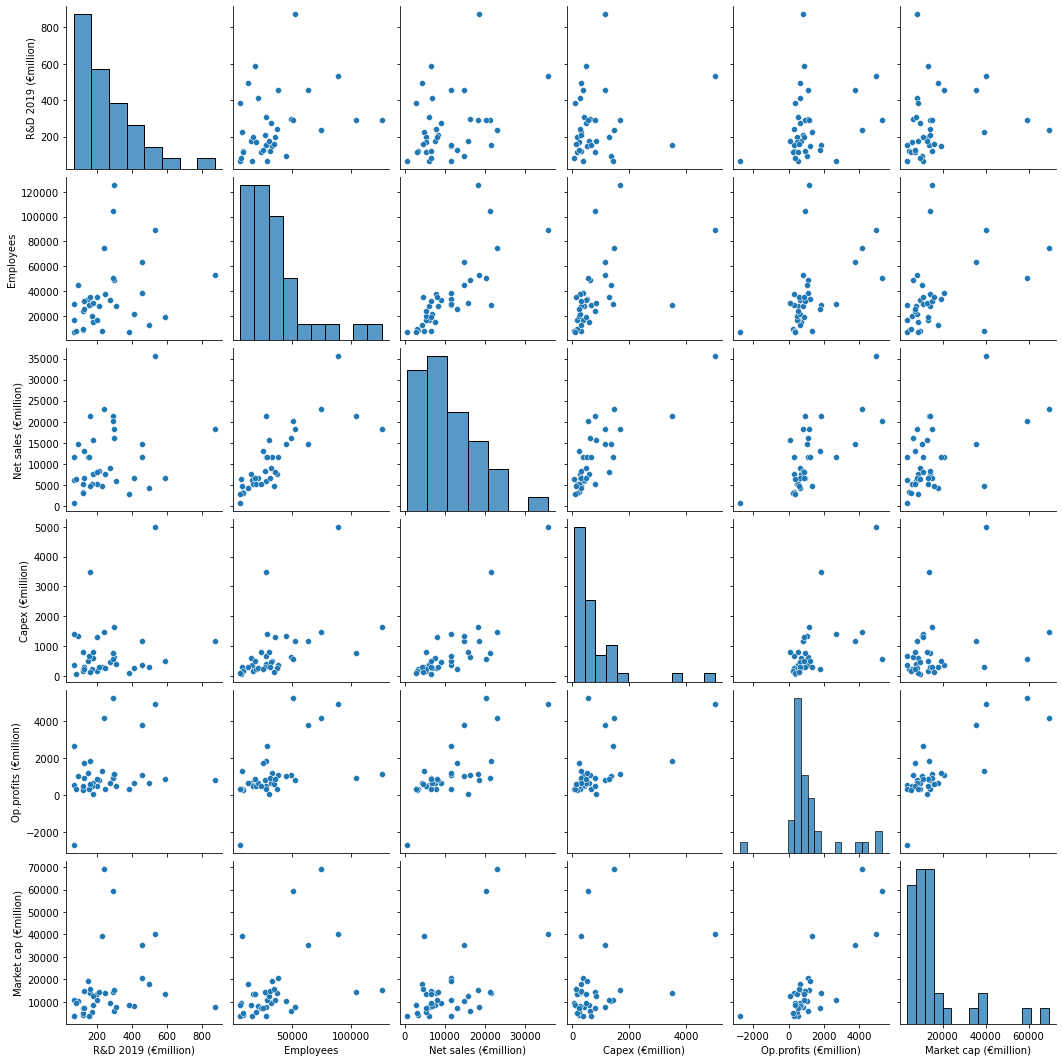

In [64]:
sns.pairplot(df_industry_avg)
plt.savefig('Images\\pairplot_industry')

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='R&D 2019 (€million)', ylabel='Industry'>

Text(0.5, 1.0, 'TOP 15 INDUSTRIES FOR AVERAGE R&D INVESTMENTS 2019 (€million)')

Text(0, 0.5, 'Industry')

Text(0.5, 0, 'R&D Investments 2019 (€million)')

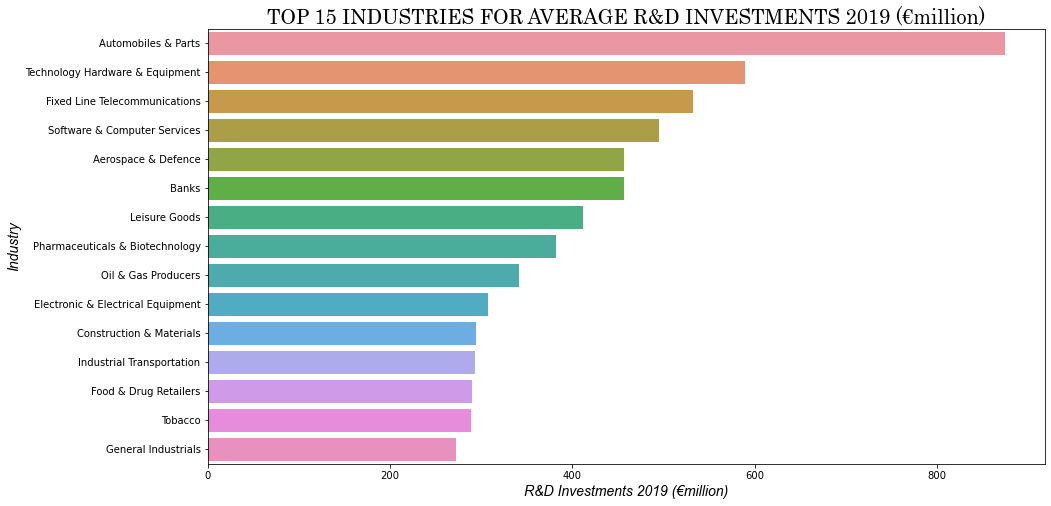

In [100]:
df_order = df_industry_avg.sort_values(by='R&D 2019 (€million)', ascending = False)
plt.figure(figsize = ((15, 8)))
sns.barplot(data = df_order[:15], x = df_order[:15]['R&D 2019 (€million)'], 
            y = df_order[:15].index)
plt.title('TOP 15 INDUSTRIES FOR AVERAGE R&D INVESTMENTS 2019 (€million)', **csfont, size = 20)
plt.ylabel('Industry', **hfont, size = 14, style = 'italic')
plt.xlabel('R&D Investments 2019 (€million)', **hfont, size = 14, style = 'italic')
plt.savefig("Images\\Average_rd_investments")

In [11]:
df_industry_avg

,R&D 2019 (€million),Employees,Net sales (€million),Capex (€million),Op.profits (€million),Market cap (€million)
Industry,,,,,,
Aerospace & Defence,456.998103,38116.512195,11520.771251,365.397062,1083.409465,20826.841106
Alternative Energy,119.106627,8479.222222,3271.627533,225.203455,322.086228,4300.940691
Automobiles & Parts,874.106089,52962.330986,18362.636303,1162.387722,795.373607,7890.973889
Banks,456.665404,63662.080000,14655.135037,1159.623844,3763.486989,35324.879503
Beverages,236.427172,74682.500000,22985.083438,1462.616340,4149.096644,69317.989157
Chemicals,177.966712,15157.636364,7480.109381,593.021310,671.787436,8713.377677
Construction & Materials,294.642798,49112.968254,16136.719619,629.338839,1083.149283,6042.632357
Electricity,156.829643,28465.818182,21407.761182,3478.772571,1813.134248,13835.658616
Electronic & Electrical Equipment,307.561781,28067.010050,6036.144517,400.102498,510.675961,7777.003390


In [65]:
for column in df_industry_avg.columns:
    if df_industry_avg[column].isnull().values.any() == True:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        df_industry_avg[column] = imputer.fit_transform(np.array(df_industry_avg[column]).reshape(-1,1))
        
df_industry_avg = df_industry_avg.round(decimals = 3)

scaler = StandardScaler()

features = scaler.fit_transform(df_industry_avg[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                                               'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']])
df_industry_avg[['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
                'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)']] = features
y = df_industry_avg['Net sales (€million)']
df_industry_avg.drop(['Net sales (€million)', 'Op.profits (€million)', 'Market cap (€million)'], axis = 1, inplace = True)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df_industry_avg, y, test_size=0.1, random_state=42)

#### Linear Regression

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predicts = lr.predict(X_test)

LinearRegression()

In [68]:
r2_score(y_test, predicts)

0.8830847955943223

In [69]:
math.sqrt(mean_squared_error(y_test, predicts))

0.34922848054852923

#### Ridge

In [70]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predicts = ridge.predict(X_test)

Ridge()

In [71]:
r2_score(y_test, predicts)

0.875449890982411

In [72]:
math.sqrt(mean_squared_error(y_test, predicts))

0.3604509825954829

#### SVR

In [73]:
svr = SVR()
svr.fit(X_train, y_train)
predicts = svr.predict(X_test)

SVR()

In [74]:
r2_score(y_test, predicts)

0.8775717345361599

In [75]:
math.sqrt(mean_squared_error(y_test, predicts))

0.35736746051571316

#### Random Forest

In [76]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predicts = rf.predict(X_test)

RandomForestRegressor()

In [77]:
r2_score(y_test, predicts)

0.781067603961939

In [78]:
math.sqrt(mean_squared_error(y_test, predicts))

0.47789135339655303

### PGM

In [82]:
df_avg = df_industry_avg.dropna()

In [83]:
def computing_high_low(dataset, column, new_column):
    lvl = []
    mean_value = np.mean(dataset[column])
    for x in dataset[column]:
        if x >= mean_value:
            lvl.append('High')
        else:
            lvl.append('Low')

    dataset[new_column] = lvl
    return dataset

df_avg = computing_high_low(df_avg, 'R&D 2019 (€million)', 'Level_R&D')
df_avg = computing_high_low(df_avg, 'Employees', 'Level_Employees')
df_avg = computing_high_low(df_avg, 'Net sales (€million)', 'Level_Net_Sales')
df_avg = computing_high_low(df_avg, 'Capex (€million)', 'Level_Capex')
df_avg = computing_high_low(df_avg, 'Op.profits (€million)', 'Level_Op_Profits')
df_avg = computing_high_low(df_avg, 'Market cap (€million)', 'Level_Market_Cap')

In [84]:
df_avg.drop(['R&D 2019 (€million)', 'Employees', 'Net sales (€million)',
       'Capex (€million)', 'Op.profits (€million)', 'Market cap (€million)'], axis = 1, inplace = True)

  0%|                                                                            | 8/1000000 [00:00<8:52:44, 31.28it/s]


<Figure size 1080x720 with 0 Axes>

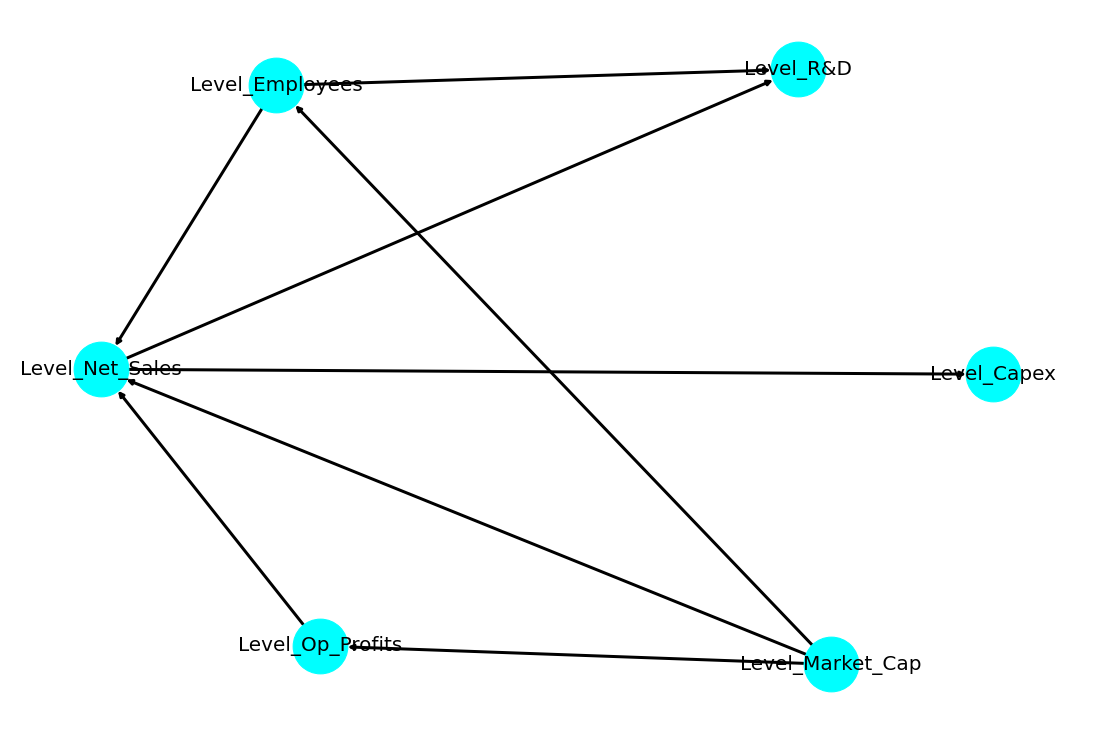

In [85]:
hc = HillClimbSearch(df_avg, scoring_method=BicScore(df_avg))
#The score to be optimized during structure estimation.  
#  Supported structure scores: k2score, bdeuscore, bicscore.
best_model = hc.estimate()
edges = list(best_model.edges())
model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))

# nx.draw(model, with_labels=True)
nx.draw(model, pos= nx.spring_layout(model), with_labels=True, node_size=3000,
        node_color="cyan", edge_color = 'black', width = 3, font_size = 20)
plt.savefig('Images\\bayesan_avg_industry.png')
plt.show()

In [86]:
model.fit(df_avg, estimator=MaximumLikelihoodEstimator)

# Doing exact inference using Variable Elimination
infer = VariableElimination(model)

In [87]:
print(infer.query(variables=['Level_Employees', 'Level_R&D'], joint= True))

Eliminating: Level_Market_Cap: 100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 385.85it/s]

+-----------------+-----------------------+----------------------------------+
| Level_R&D       | Level_Employees       |   phi(Level_R&D,Level_Employees) |
+=================+=======================+==================================+
| Level_R&D(High) | Level_Employees(High) |                           0.2175 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(High) | Level_Employees(Low)  |                           0.1755 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(Low)  | Level_Employees(High) |                           0.0881 |
+-----------------+-----------------------+----------------------------------+
| Level_R&D(Low)  | Level_Employees(Low)  |                           0.5189 |
+-----------------+-----------------------+----------------------------------+


In [88]:
print(infer.query(variables=['Level_Employees'], evidence={'Level_R&D': 'High'}))

Eliminating: Level_Market_Cap: 100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 567.22it/s]

+-----------------------+------------------------+
| Level_Employees       |   phi(Level_Employees) |
+=======================+========================+
| Level_Employees(High) |                 0.5533 |
+-----------------------+------------------------+
| Level_Employees(Low)  |                 0.4467 |
+-----------------------+------------------------+


In [89]:
print(infer.query(variables=['Level_Employees'], evidence={'Level_R&D': 'Low'}))


Finding Elimination Order: :   0%|                                                               | 0/4 [00:00<?, ?it/s]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Op_Profits:   0%|                                                             | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Capex:   0%|                                                                  | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Net_Sales:   0%|                                                              | 0/4 [00:00<?, ?it/s]

Eliminating: Level_Market_Cap: 100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 445.66it/s]

+-----------------------+------------------------+
| Level_Employees       |   phi(Level_Employees) |
+=======================+========================+
| Level_Employees(High) |                 0.1451 |
+-----------------------+------------------------+
| Level_Employees(Low)  |                 0.8549 |
+-----------------------+------------------------+


In [90]:
print(infer.query(variables=['Level_Net_Sales'], evidence={'Level_R&D': 'High', 'Level_Employees': 'High', 'Level_Capex':'High'}))



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|                                                               | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


Eliminating: Level_Op_Profits:   0%|                                                             | 0/2 [00:00<?, ?it/s]


Eliminating: Level_Market_Cap: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 571.35it/s]

+-----------------------+------------------------+
| Level_Net_Sales       |   phi(Level_Net_Sales) |
+=======================+========================+
| Level_Net_Sales(High) |                 1.0000 |
+-----------------------+------------------------+
| Level_Net_Sales(Low)  |                 0.0000 |
+-----------------------+------------------------+


In [91]:
print(infer.query(variables=['Level_Net_Sales'], evidence={'Level_R&D': 'Low', 'Level_Employees': 'Low', 'Level_Capex':'Low'}))




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


Finding Elimination Order: :   0%|                                                               | 0/2 [00:00<?, ?it/s]



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]



Eliminating: Level_Op_Profits:   0%|                                                             | 0/2 [00:00<?, ?it/s]



Eliminating: Level_Market_Cap: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.29it/s]

+-----------------------+------------------------+
| Level_Net_Sales       |   phi(Level_Net_Sales) |
+=======================+========================+
| Level_Net_Sales(High) |                 0.1504 |
+-----------------------+------------------------+
| Level_Net_Sales(Low)  |                 0.8496 |
+-----------------------+------------------------+


In [53]:
for x in list(df_avg.columns):
        new_name = x.replace(' ', '.')
        new_name = new_name.replace('€', '')
        new_name = new_name.replace('(', '')
        new_name = new_name.replace(')', '')
        new_name = new_name.replace('&', '')
        df_avg.rename(columns = {x : new_name}, inplace = True)

In [55]:
df_avg.columns

Index(['RD.2019.million', 'Employees', 'Net.sales.million', 'Capex.million',
       'Op.profits.million', 'Market.cap.million'],
      dtype='object')

In [56]:
df_avg.to_csv('Dataset\\df_avg_industry.csv')